<a href="https://colab.research.google.com/github/tharushidithya/DTprogramTrackingBoard/blob/master/fine_tuning_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn

In [2]:
import pandas as pd
from datasets import list_datasets

In [3]:
all_datasets = list_datasets()

<ipython-input-3-f6f3a82aff2d>:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
'dair-ai/emotion' in all_datasets

True

In [5]:
from datasets import load_dataset
emotion = load_dataset('emotion')
emotion.set_format(type='pandas')

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
df = emotion['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [7]:
classes = emotion['train'].features['label'].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [8]:
df['label_name'] = df['label'].apply(lambda x: classes[x])

In [9]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# Dataset analysis

In [10]:
import matplotlib.pyplot as plt

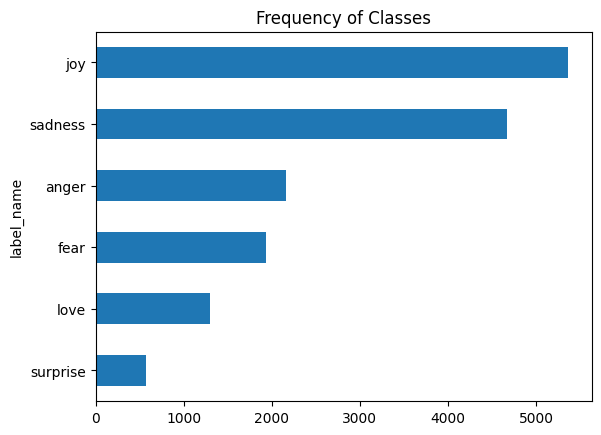

In [11]:
label_counts = df['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title('Frequency of Classes')
plt.show()

<Axes: title={'center': 'Words per sentence'}, xlabel='label_name'>

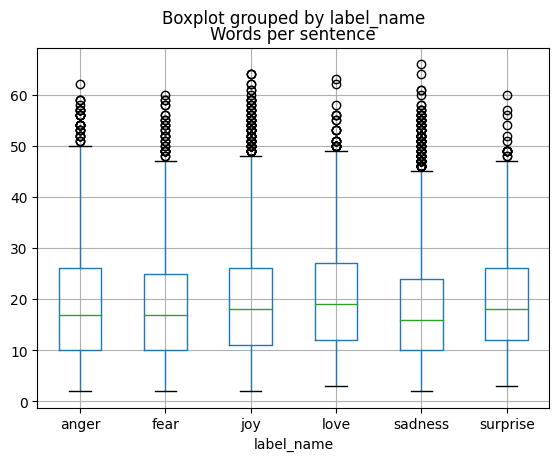

In [12]:
df['Words per sentence'] = df['text'].str.split().apply(len)
df.boxplot("Words per sentence", by='label_name')

# Text to Tokens Conversion

In [13]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
text = "I love Machine Learning!. Tokenization is awesome"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 1012, 19204, 3989, 2003, 12476, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [15]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'i', 'love', 'machine', 'learning', '!', '.', 'token', '##ization', 'is', 'awesome', '[SEP]']


In [16]:
tokenizer.vocab_size, tokenizer.model_max_length

(30522, 512)

## Tokenization of Emotion Data

In [17]:
emotion.reset_format()

In [18]:
# map() method would be used

def tokenize(batch):
  temp =tokenizer(batch['text'], padding=True, truncation=True)
  return temp

print(tokenize(emotion["train"][:5]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2572, 2412, 3110, 16839, 9080, 12863, 2055, 1996, 13788, 1045, 2097, 2113, 2008, 2009, 2003, 2145, 2006, 1996, 3200, 102, 0], [101, 1045, 2572, 3110, 24665, 7140, 11714, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [19]:
emotions_encoded = emotion.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [20]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

# Model Building

In [21]:
text

'I love Machine Learning!. Tokenization is awesome'

In [22]:
inputs = tokenizer(text, return_tensors='pt')
inputs

{'input_ids': tensor([[  101,  1045,  2293,  3698,  4083,   999,  1012, 19204,  3989,  2003,
         12476,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [23]:
from transformers import AutoModel
import torch

model = AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [24]:
with torch.no_grad():
  outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

In [25]:
last_hidden_states.shape

torch.Size([1, 12, 768])

# Fine-tuning Transformer

In [26]:
from transformers import AutoModelForSequenceClassification

num_labels = len(classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
device

device(type='cuda')

In [28]:
from transformers import TrainingArguments

In [51]:
batch_size = 64
model_name = "distilbert-finetuned-emotion"

training_args = TrainingArguments(output_dir = model_name,
                                 num_train_epochs=10,
                                 learning_rate = 2e-5,
                                 per_device_train_batch_size= batch_size,
                                 per_device_eval_batch_size = batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy = 'epoch',
                                  disable_tqdm=False)

In [52]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [53]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [54]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.167783,0.931000,0.931448
2,0.148600,0.160239,0.933000,0.933429
3,0.148600,0.145578,0.940500,0.940929
4,0.091000,0.153435,0.940000,0.940044
5,0.091000,0.158882,0.938000,0.937251
6,0.058700,0.157467,0.939500,0.939614
7,0.058700,0.175997,0.936500,0.936414
8,0.037800,0.184890,0.939500,0.939312
9,0.037800,0.191886,0.944000,0.943834
10,0.025400,0.192682,0.940500,0.940478


TrainOutput(global_step=2500, training_loss=0.07230156402587891, metrics={'train_runtime': 1269.803, 'train_samples_per_second': 126.004, 'train_steps_per_second': 1.969, 'total_flos': 3601714308480000.0, 'train_loss': 0.07230156402587891, 'epoch': 10.0})

In [55]:
preds_outputs = trainer.predict(emotions_encoded['test'])
preds_outputs.metrics

{'test_loss': 0.25194433331489563,
 'test_accuracy': 0.9215,
 'test_f1': 0.9214688846600824,
 'test_runtime': 3.996,
 'test_samples_per_second': 500.5,
 'test_steps_per_second': 8.008}

In [56]:
import numpy as np
y_preds = np.argmax(preds_outputs.predictions, axis=1)
y_true = emotions_encoded['test'][:]['label']

In [57]:
from sklearn.metrics import classification_report
print(classes)
print(classification_report(y_true, y_preds))

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       581
           1       0.94      0.93      0.94       695
           2       0.79      0.82      0.81       159
           3       0.92      0.93      0.93       275
           4       0.88      0.91      0.89       224
           5       0.73      0.67      0.70        66

    accuracy                           0.92      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.92      0.92      0.92      2000



In [58]:
label_counts

label_name
surprise     572
love        1304
fear        1937
anger       2159
sadness     4666
joy         5362
Name: count, dtype: int64

In [60]:
text = 'i do not like you, i am sorry'
input_encoded = tokenizer(text, return_tensors='pt').to(device)
with torch.no_grad():
  outputs = model(**input_encoded)

logits = outputs.logits
pred = torch.argmax(logits, dim=1).item()
pred, classes[pred]

(0, 'sadness')

In [61]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ 7.9720, -2.2090, -3.0169, -0.7871, -1.7164, -3.3333]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [62]:
!zip -r /content/file.zip /content/distilbert-finetuned-emotion

  adding: content/distilbert-finetuned-emotion/ (stored 0%)
  adding: content/distilbert-finetuned-emotion/checkpoint-2000/ (stored 0%)
  adding: content/distilbert-finetuned-emotion/checkpoint-2000/optimizer.pt (deflated 27%)
  adding: content/distilbert-finetuned-emotion/checkpoint-2000/config.json (deflated 52%)
  adding: content/distilbert-finetuned-emotion/checkpoint-2000/trainer_state.json (deflated 74%)
  adding: content/distilbert-finetuned-emotion/checkpoint-2000/tokenizer_config.json (deflated 76%)
  adding: content/distilbert-finetuned-emotion/checkpoint-2000/special_tokens_map.json (deflated 42%)
  adding: content/distilbert-finetuned-emotion/checkpoint-2000/vocab.txt (deflated 53%)
  adding: content/distilbert-finetuned-emotion/checkpoint-2000/rng_state.pth (deflated 25%)
  adding: content/distilbert-finetuned-emotion/checkpoint-2000/tokenizer.json (deflated 71%)
  adding: content/distilbert-finetuned-emotion/checkpoint-2000/scheduler.pt (deflated 55%)
  adding: content/di